# Beyond Accuracy: Comprehensive Classification Evaluation Techniques

## Notebook Contents Structure

1. Introduction and Dataset Preparation (Dataset: UCI Heart Disease dataset (real medical data), Data exploration and preprocessing, Train-test split with stratification)
2. Classification Metrics Implementation( Accuracy, Precision, Recall,, F1-score, Class-specific metrics, ROC AUC and PR AUC, Mean Average Precision (mAP), Matthews Correlation Coefficient)
3. Visualization Techniques
- **Confusion Matrix Visualization** (Raw, normalized, and class-weighted versions, Error analysis of misclassified cases)
- **ROC and PR Curves** (Multiple model comparison, Confidence bands, Threshold selection visualization )
- **Learning Curves Analysis** (Training vs. validation performance, Detecting overfitting and underfitting, Sample efficiency analysis)
- **Hyperparameter Visualization** (Learning rate impact on convergence, Parameter importance plots, Cross-validation stability analysis)
4. Model Optimization Case Study (Threshold optimization for business metrics, Model comparison and selection, Ensemble techniques)

In [1]:
# Libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Metrics imports
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, precision_recall_curve, roc_curve, auc,
                            average_precision_score, confusion_matrix, classification_report,
                            matthews_corrcoef)

# Model imports
from sklearn.model_selection import (train_test_split, cross_val_score,
                                    learning_curve, validation_curve, GridSearchCV,
                                    StratifiedKFold, KFold)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

In [2]:
# Custom plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Data Preparation

### Data Loading and Exploration

Dataset shape: (297, 14)
Target distribution: target
0    160
1    137
Name: count, dtype: int64
Positive cases: 137 (46.1%)


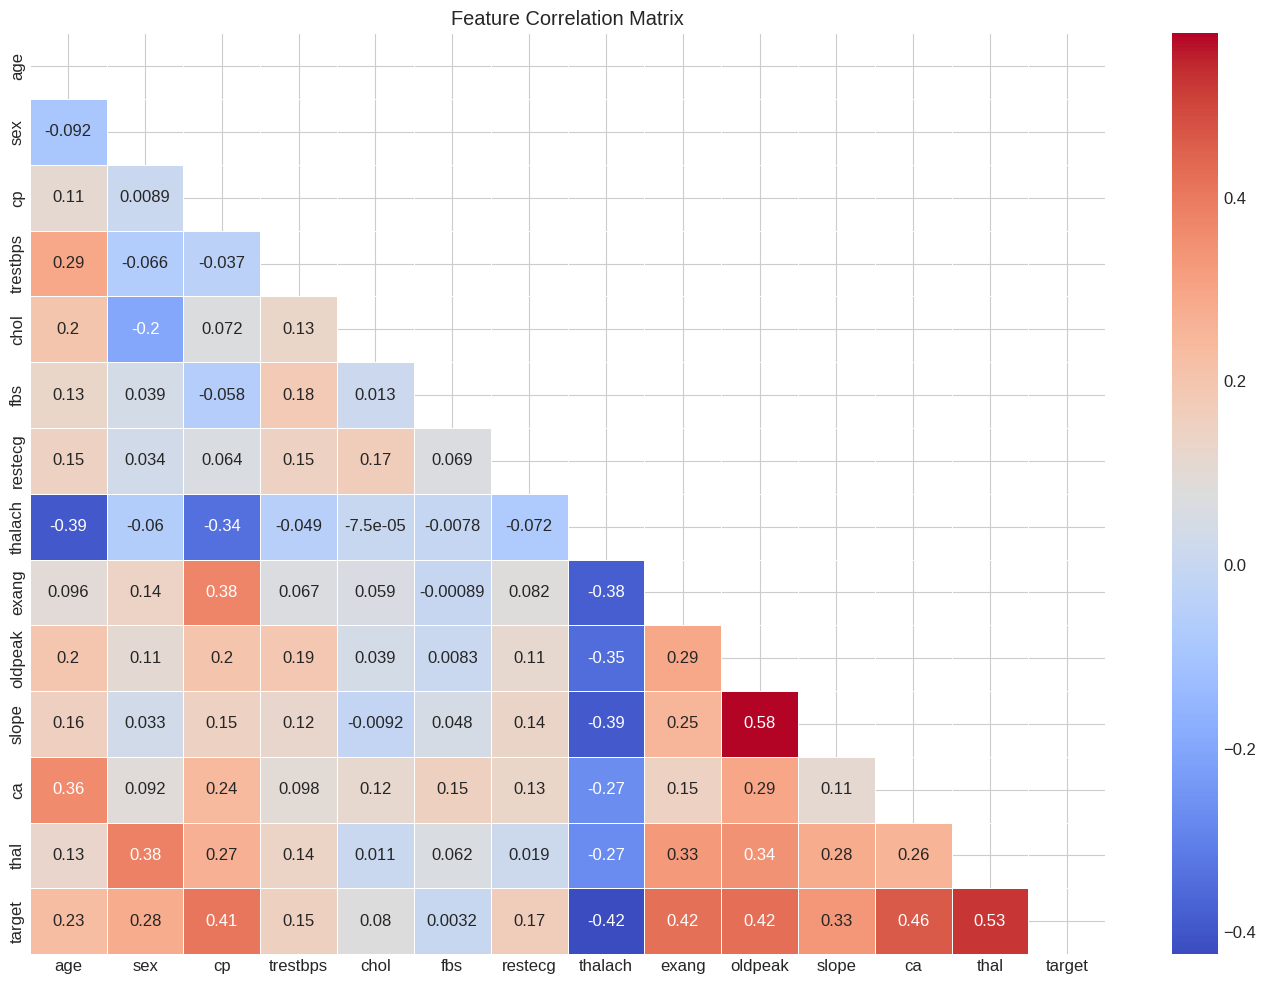

In [3]:
# Heart Disease Dataset (UCI)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=column_names, na_values='?')

# Basic data cleaning
data['ca'] = pd.to_numeric(data['ca'], errors='coerce')
data['thal'] = pd.to_numeric(data['thal'], errors='coerce')
data.dropna(inplace=True)

# Binarize target (0 = no disease, 1 = disease)
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

# Exploratory analysis
print(f"Dataset shape: {data.shape}")
print(f"Target distribution: {data['target'].value_counts()}")
print(f"Positive cases: {data['target'].sum()} ({data['target'].mean():.1%})")

# Feature correlation heatmap
plt.figure(figsize=(14, 10))
correlation = data.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Data Preprocessing and Splitting

In [4]:
# Split features and target
X = data.drop('target', axis=1)
y = data['target']

# Train-test split with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Initialize cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create processing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

## 1. Model Training and Basic Evaluation

In [5]:
# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

In [6]:
# Training and evaluation results
results = {}
y_pred_dict = {}
y_prob_dict = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Create pipeline with current model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Store results
    y_pred_dict[name] = y_pred
    y_prob_dict[name] = y_prob

    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'pr_auc': average_precision_score(y_test, y_prob),
        'mcc': matthews_corrcoef(y_test, y_pred)
    }

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM...


In [7]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)
display(results_df)

,accuracy,precision,recall,f1,roc_auc,pr_auc,mcc
Logistic Regression,0.853,0.853,0.829,0.841,0.947,0.929,0.705
Random Forest,0.853,0.853,0.829,0.841,0.934,0.916,0.705
Gradient Boosting,0.827,0.824,0.800,0.812,0.888,0.840,0.651
SVM,0.853,0.875,0.800,0.836,0.950,0.938,0.706


## Advanced Metric Calculation


In [8]:
def calculate_class_metrics(y_true, y_pred):
    """Calculate metrics specifically for each class"""
    classes = np.unique(y_true)
    class_metrics = {}

    for c in classes:
        # Convert to binary classification problem for this class
        y_true_binary = (y_true == c).astype(int)
        y_pred_binary = (y_pred == c).astype(int)

        class_metrics[f'Class {c}'] = {
            'precision': precision_score(y_true_binary, y_pred_binary),
            'recall': recall_score(y_true_binary, y_pred_binary),
            'f1': f1_score(y_true_binary, y_pred_binary),
            'support': np.sum(y_true_binary)
        }

    return class_metrics

In [10]:
# Calculate class-specific metrics for each model
class_metrics = {}
for name, y_pred in y_pred_dict.items():
    class_metrics[name] = calculate_class_metrics(y_test, y_pred)

# Display class-specific metrics for best model
best_model = results_df['f1'].idxmax()
display(pd.DataFrame(class_metrics[best_model]))

,Class 0,Class 1
precision,0.853659,0.852941
recall,0.875000,0.828571
f1,0.864198,0.840580
support,40.000000,35.000000


## Confusion Matrix Visualization

In [13]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plot an enhanced confusion matrix with percentages and counts"""
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100

    # Text annotations format
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            annot[i, j] = f'{cm[i, j]} ({cm_perc[i, j]:.1f}%)'

    # Plot
    fig, ax = plt.subplots(figsize=(4, 2))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=False, ax=ax)

    # Labels
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)

    # Tick labels
    ax.xaxis.set_ticklabels(['No Disease', 'Disease'])
    ax.yaxis.set_ticklabels(['No Disease', 'Disease'])

    # Add error analysis info
    false_positives = cm[0, 1]
    false_negatives = cm[1, 0]
    fp_rate = false_positives / np.sum(cm[0, :]) * 100
    fn_rate = false_negatives / np.sum(cm[1, :]) * 100

    plt.figtext(0.5, 0.01, f'False Positive Rate: {fp_rate:.1f}% | False Negative Rate: {fn_rate:.1f}%',
               ha='center', fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.tight_layout()
    return fig

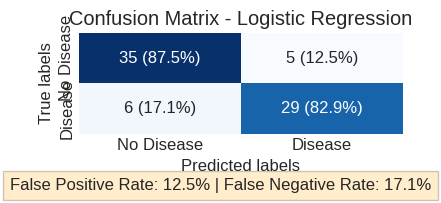

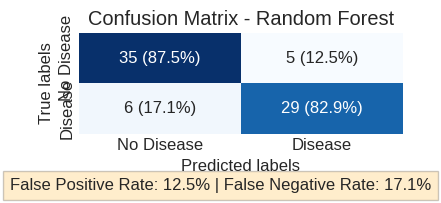

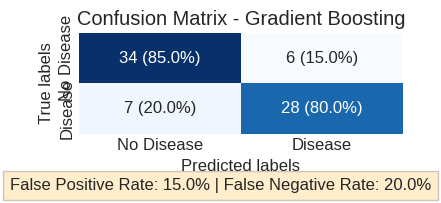

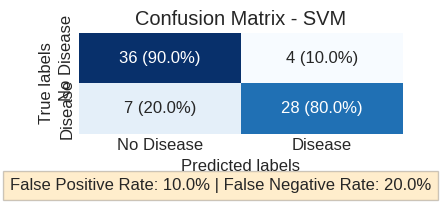

In [14]:
# Plot confusion matrices for each model
for name, y_pred in y_pred_dict.items():
    fig = plot_confusion_matrix(y_test, y_pred, title=f'Confusion Matrix - {name}')
    plt.show()

## ROC and PR Curves Visualization

In [21]:
def plot_roc_curves(y_true, y_prob_dict, title='ROC Curves'):
    """Plot ROC curves for multiple models with confidence intervals"""
    plt.figure(figsize=(12, 10))

    # Plot random classifier
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # Plot for each model with confidence intervals
    for i, (name, y_prob) in enumerate(y_prob_dict.items()):
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)

        # Generate bootstrap intervals
        n_bootstraps = 1000
        bootstrapped_aucs = []
        rng = np.random.RandomState(42)
        for j in range(n_bootstraps):
            indices = rng.randint(0, len(y_prob), len(y_prob))
            # Ensure the bootstrapped sample contains both classes
            # Access using iloc for positional indexing and then get values
            y_true_boot = y_true.iloc[indices].values
            if len(np.unique(y_true_boot)) < 2:
                continue
            y_prob_boot = y_prob[indices]

            bootstrapped_aucs.append(roc_auc_score(y_true_boot, y_prob_boot))

        # Calculate 95% confidence intervals
        sorted_aucs = np.array(bootstrapped_aucs)
        sorted_aucs.sort()
        ci_lower = sorted_aucs[int(0.025 * len(sorted_aucs))]
        ci_upper = sorted_aucs[int(0.975 * len(sorted_aucs))]

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, color=colors[i % len(colors)],
                 label=f'{name} (AUC = {roc_auc:.3f}, 95% CI: [{ci_lower:.3f}-{ci_upper:.3f}])')

        # Add confidence interval
        plt.fill_between(fpr,
                         np.maximum(tpr - (roc_auc - ci_lower), 0),
                         np.minimum(tpr + (ci_upper - roc_auc), 1),
                         color=colors[i % len(colors)], alpha=0.2)

        # Mark the point corresponding to the default threshold of 0.5
        idx = np.argmin(np.abs(thresholds - 0.5))
        plt.scatter(fpr[idx], tpr[idx], marker='o', color=colors[i % len(colors)], s=100,
                   label=f'{name} (threshold=0.5)')

    # Styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Add explanatory annotation
    plt.annotate('Better performance', xy=(0.2, 0.8), xytext=(0.4, 0.6),
            arrowprops=dict(facecolor='black', shrink=0.05))

    plt.grid(True)
    plt.tight_layout()
    return plt.gcf()

def plot_pr_curves(y_true, y_prob_dict, title='Precision-Recall Curves'):
    """Plot PR curves for multiple models"""
    plt.figure(figsize=(12, 10))

    # Calculate baseline based on class distribution
    baseline = np.sum(y_true) / len(y_true)
    plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (No Skill): {baseline:.3f}')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # Plot for each model
    for i, (name, y_prob) in enumerate(y_prob_dict.items()):
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)

        # Plot PR curve
        plt.plot(recall, precision, lw=2, color=colors[i % len(colors)],
                label=f'{name} (PR AUC = {pr_auc:.3f})')

        # Add markers for different threshold values
        thresholds = np.append(thresholds, 1.0)  # Add endpoint
        threshold_markers = [0.3, 0.5, 0.7, 0.9]
        for threshold in threshold_markers:
            idx = np.argmin(np.abs(thresholds - threshold))
            plt.scatter(recall[idx], precision[idx], marker='o', color=colors[i % len(colors)])
            plt.annotate(f'{threshold}', (recall[idx], precision[idx]),
                        textcoords="offset points", xytext=(0,10), ha='center')

    # Styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")

    # Add high-precision region highlight
    plt.axvspan(0, 0.4, alpha=0.1, color='green')
    plt.annotate('High Precision Region', xy=(0.2, 0.5), ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="green", alpha=0.1))

    plt.grid(True)
    plt.tight_layout()
    return plt.gcf()

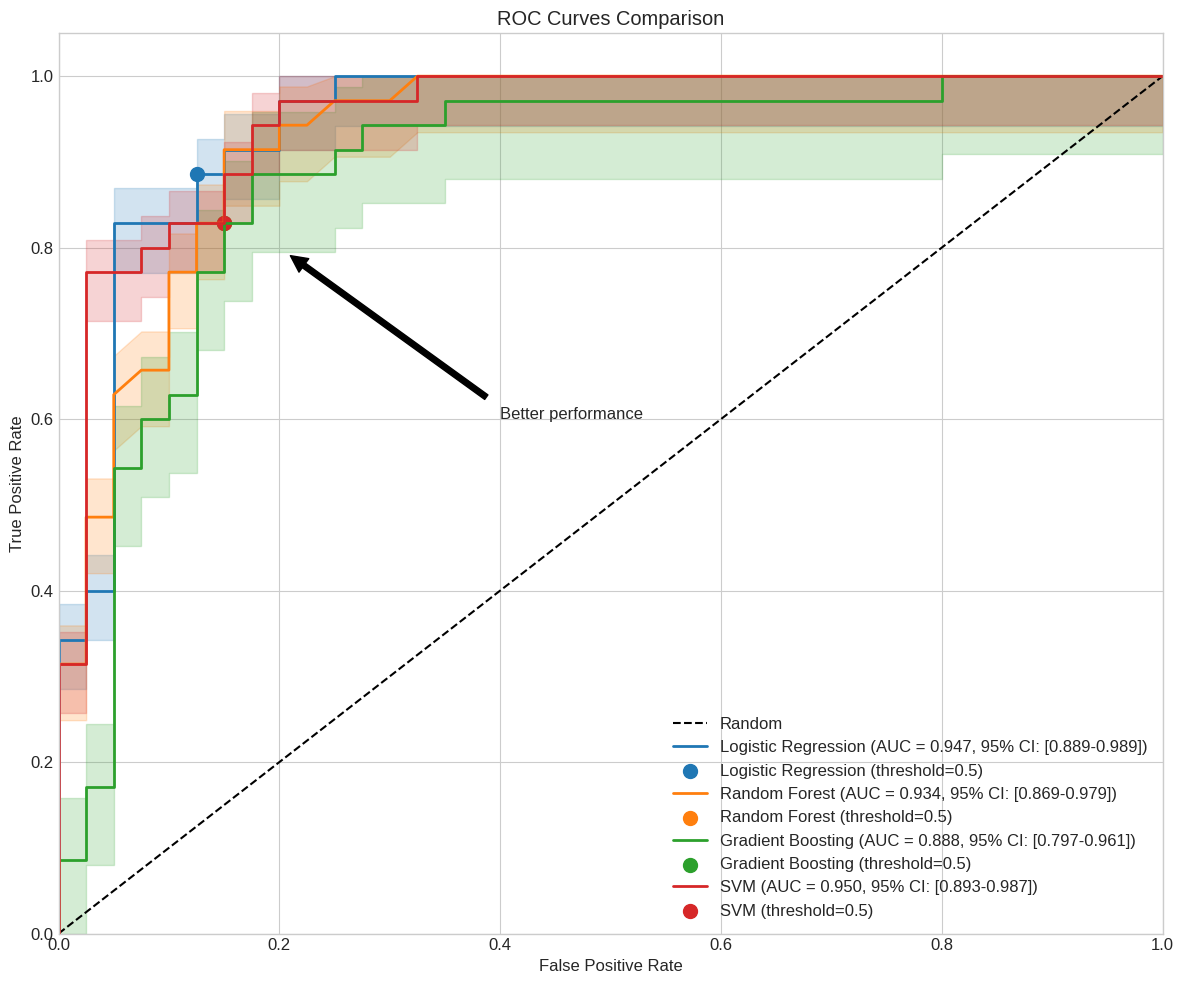

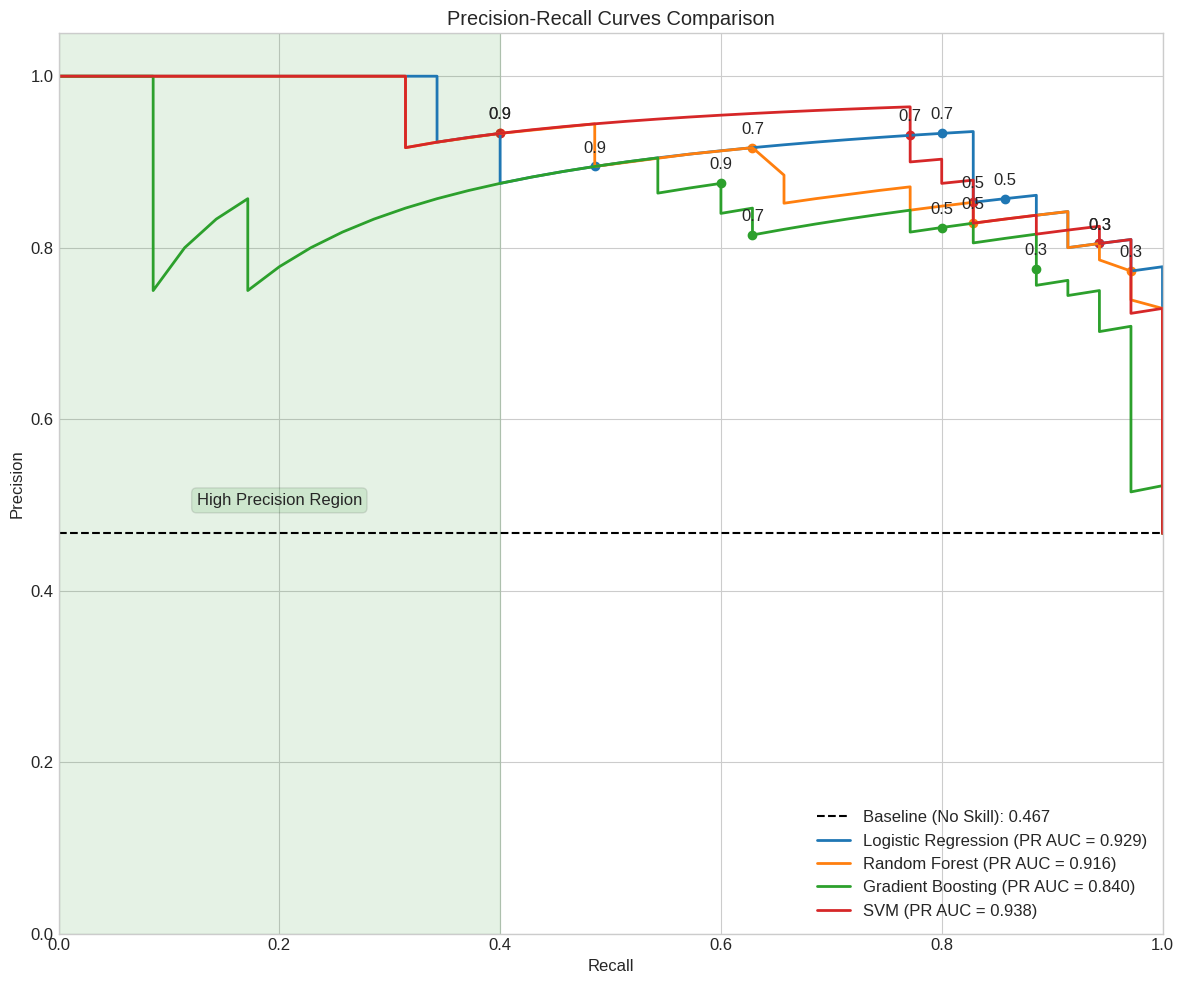

In [22]:
# Plot ROC and PR curves
roc_fig = plot_roc_curves(y_test, y_prob_dict, title='ROC Curves Comparison')
plt.show()

pr_fig = plot_pr_curves(y_test, y_prob_dict, title='Precision-Recall Curves Comparison')
plt.show()

## Threshold Analysis

In [24]:
def plot_threshold_analysis(y_true, y_prob, title='Threshold Analysis'):
    """
    Visualize how different metrics change with threshold variation
    """
    thresholds = np.arange(0.01, 1.0, 0.01)

    metrics = {
        'Precision': [],
        'Recall': [],
        'F1 Score': [],
        'Accuracy': []
    }

    # Calculate metrics at different thresholds
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        metrics['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
        metrics['Recall'].append(recall_score(y_true, y_pred))
        metrics['F1 Score'].append(f1_score(y_true, y_pred))
        metrics['Accuracy'].append(accuracy_score(y_true, y_pred))

    # Set up figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot metrics
    for name, values in metrics.items():
        ax.plot(thresholds, values, lw=2, label=name)

    # Mark optimal F1 threshold
    optimal_f1_idx = np.argmax(metrics['F1 Score'])
    optimal_threshold = thresholds[optimal_f1_idx]

    ax.axvline(x=optimal_threshold, color='k', linestyle='--', alpha=0.7,
              label=f'Optimal F1 Threshold: {optimal_threshold:.2f}')
    ax.plot(optimal_threshold, metrics['F1 Score'][optimal_f1_idx], 'ko', ms=8)

    # Default threshold reference
    ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.7, label='Default Threshold: 0.5')

    # Styling
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Metric Value')
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True)

    # Add regions
    ax.axvspan(0, 0.3, alpha=0.1, color='green', label='High Recall')
    ax.axvspan(0.7, 1.0, alpha=0.1, color='blue', label='High Precision')

    plt.tight_layout()
    return fig

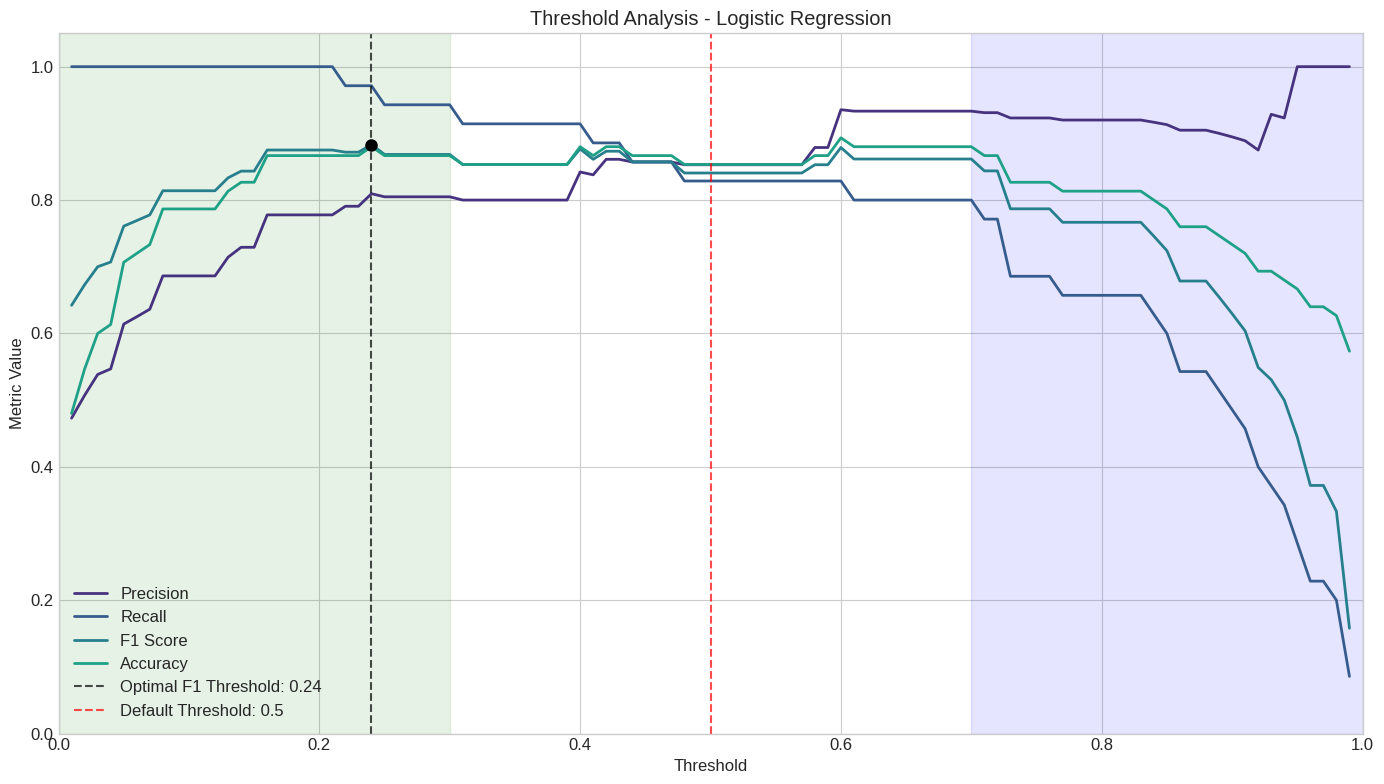

In [25]:
# Analyze thresholds for best model
best_model = results_df['f1'].idxmax()
threshold_fig = plot_threshold_analysis(y_test, y_prob_dict[best_model],
                                       title=f'Threshold Analysis - {best_model}')
plt.show()

## Learning Curves and Overfitting/Underfitting Analysis

In [26]:
def plot_learning_curves(estimator, X, y, title="Learning Curves"):
    """
    Plot learning curves to diagnose overfitting/underfitting
    """
    # Setup cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create pipeline with preprocessing
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', estimator)
    ])

    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        pipe, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1', random_state=42
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(14, 8))
    plt.grid()

    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - val_std,
                     val_mean + val_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation score')

    # Diagnose overfitting/underfitting
    gap = train_mean[-1] - val_mean[-1]
    train_max = train_mean[-1]
    val_max = val_mean[-1]

    if gap > 0.1 and train_max > 0.9:
        plt.text(train_sizes[-1]*0.7, 0.3, "Overfitting",
                fontsize=14, bbox=dict(facecolor='red', alpha=0.2))
    elif train_max < 0.8 and val_max < 0.8:
        plt.text(train_sizes[-1]*0.7, 0.3, "Underfitting",
                fontsize=14, bbox=dict(facecolor='blue', alpha=0.2))
    else:
        plt.text(train_sizes[-1]*0.7, 0.3, "Good Fit",
                fontsize=14, bbox=dict(facecolor='green', alpha=0.2))

    # Add arrows showing gap
    plt.annotate('', xy=(train_sizes[-1], train_mean[-1]),
                xytext=(train_sizes[-1], val_mean[-1]),
                arrowprops=dict(arrowstyle='<->', color='purple'))
    plt.text(train_sizes[-1]*1.01, train_mean[-1] - gap/2, f'Gap: {gap:.2f}',
            verticalalignment='center', color='purple')

    # More data prediction line
    if val_mean[-1] < val_mean[-2]:
        trend = "↓ More data might not help"
    else:
        trend = "↑ More data might help"

    plt.annotate(trend, xy=(train_sizes[-1], val_mean[-1]),
                xytext=(train_sizes[-1]*1.05, val_mean[-1]),
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

    # Styling
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.title(title)
    plt.legend(loc="best")
    plt.tight_layout()

    return plt.gcf()

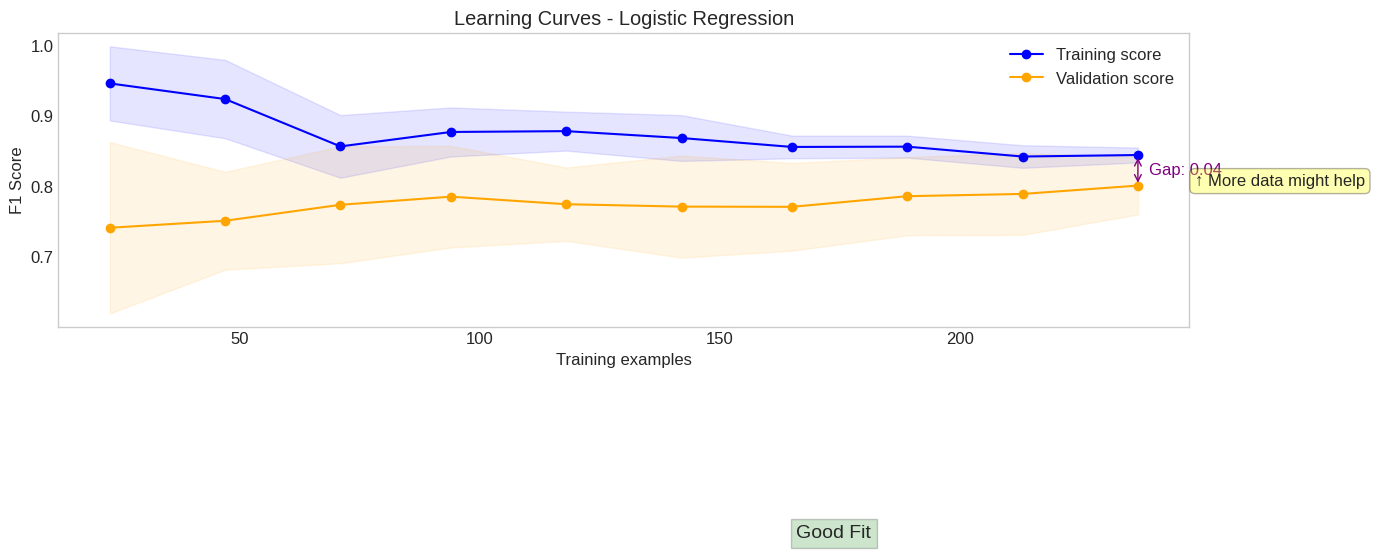

In [27]:
# Plot learning curves for best model
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]
lc_fig = plot_learning_curves(best_model, X, y,
                            title=f"Learning Curves - {best_model_name}")
plt.show()

## Learning Rate Analysis

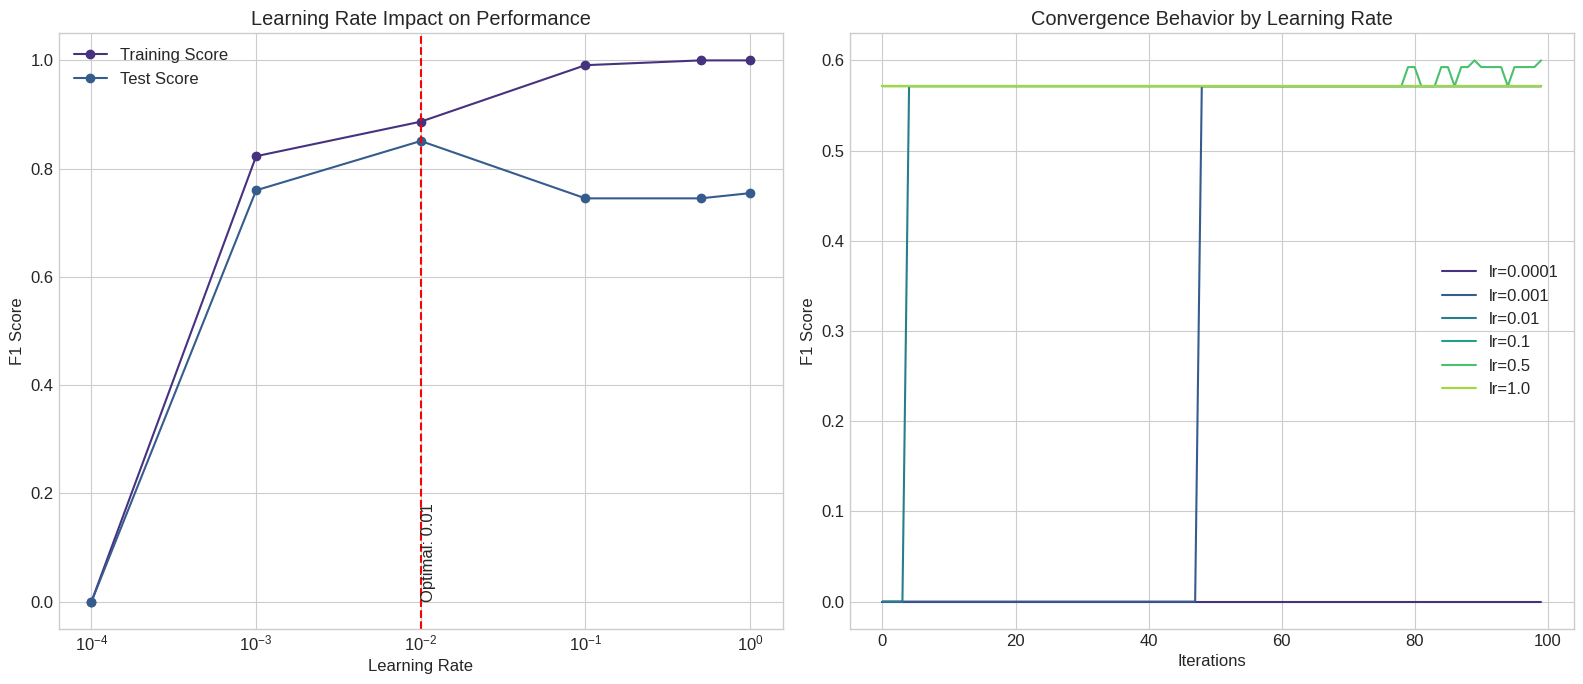

In [29]:
def plot_learning_rate_analysis(X, y, base_model=None):
    """
    Analyze the impact of learning rate on model performance
    """
    from sklearn.base import clone
    if base_model is None:
        base_model = GradientBoostingClassifier(random_state=42)

    # Define learning rates to test
    learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
    results = {'train': [], 'test': []}
    convergence = {}

    # Setup cross validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Test each learning rate
    for lr in learning_rates:
        if hasattr(base_model, 'learning_rate'):
            model = clone(base_model)
            model.learning_rate = lr
        elif hasattr(base_model, 'eta0'):
            model = clone(base_model)
            model.eta0 = lr
        else:
            # Use MLP if original model doesn't support learning rate
            model = MLPClassifier(learning_rate_init=lr, max_iter=500, random_state=42)

        # Create pipeline with preprocessing
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])

        # Train model
        pipe.fit(X_train, y_train)

        # Evaluate
        train_score = f1_score(y_train, pipe.predict(X_train))
        test_score = f1_score(y_cv, pipe.predict(X_cv))

        results['train'].append(train_score)
        results['test'].append(test_score)

        # Get learning curve if model has staged_predict
        if hasattr(model, 'staged_predict_proba'):
            staged_scores = []
            for y_pred in model.staged_predict(X_cv):
                staged_scores.append(f1_score(y_cv, y_pred))
            convergence[f'lr={lr}'] = staged_scores

    # Plot learning rate impact on performance
    ax1.plot(learning_rates, results['train'], 'o-', label='Training Score')
    ax1.plot(learning_rates, results['test'], 'o-', label='Test Score')
    ax1.set_xscale('log')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('F1 Score')
    ax1.set_title('Learning Rate Impact on Performance')
    ax1.grid(True)
    ax1.legend()

    # Mark the optimal learning rate
    best_idx = np.argmax(results['test'])
    best_lr = learning_rates[best_idx]
    ax1.axvline(x=best_lr, color='r', linestyle='--')
    ax1.text(best_lr, min(results['test']), f'Optimal: {best_lr}',
            rotation=90, verticalalignment='bottom')

    # Plot convergence with different learning rates
    if convergence:
        for name, scores in convergence.items():
            iterations = np.arange(len(scores))
            ax2.plot(iterations, scores, label=name)

        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('F1 Score')
        ax2.set_title('Convergence Behavior by Learning Rate')
        ax2.grid(True)
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "Model does not support staged prediction",
                ha='center', va='center', transform=ax2.transAxes)

    plt.tight_layout()
    return fig

# Only run this for gradient boosting or similar models with learning rate
if 'Gradient Boosting' in models:
    lr_fig = plot_learning_rate_analysis(X, y, models['Gradient Boosting'])
    plt.show()

## Cross-validation Stability Analysis

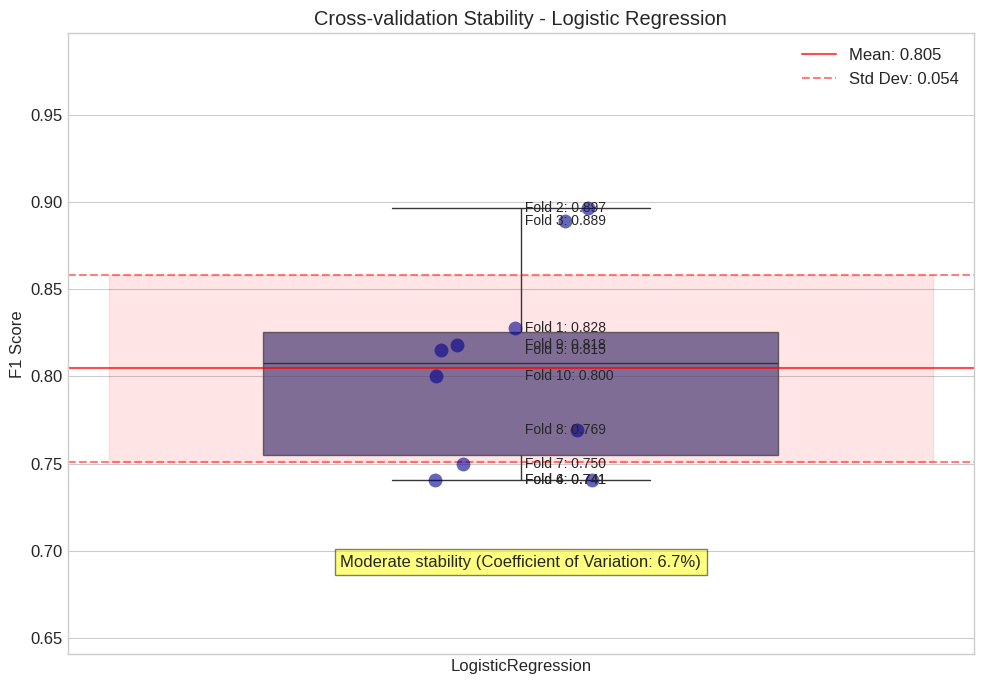

In [32]:
def plot_cv_stability(estimator, X, y, cv=5, metric='f1', title="Cross-validation Stability"):
    """
    Visualize model stability across cross-validation folds
    """
    cv_method = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Create pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', estimator)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipe, X, y, cv=cv_method, scoring=metric)

    # Create a DataFrame for plotting with seaborn
    plot_df = pd.DataFrame({
        'Model': [estimator.__class__.__name__] * len(cv_scores),
        f'{metric.upper()} Score': cv_scores
    })

    # Visualize with box plot
    plt.figure(figsize=(10, 7))

    # Use the DataFrame for plotting
    sns.stripplot(x='Model', y=f'{metric.upper()} Score', data=plot_df,
                  size=10, jitter=True, color='darkblue', alpha=0.6)

    sns.boxplot(x='Model', y=f'{metric.upper()} Score', data=plot_df,
                whis=np.inf, boxprops=dict(alpha=.7), width=0.5)

    # Add individual fold annotations (requires iterating over the original scores)
    for i, score in enumerate(cv_scores):
        plt.text(0, score, f' Fold {i+1}: {score:.3f}',
                verticalalignment='center', fontsize=10)

    # Stats
    mean = np.mean(cv_scores)
    std = np.std(cv_scores)

    # Add summary stats
    plt.axhline(y=mean, color='r', linestyle='-', alpha=0.7,
               label=f'Mean: {mean:.3f}')
    plt.axhline(y=mean+std, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=mean-std, color='r', linestyle='--', alpha=0.5,
               label=f'Std Dev: {std:.3f}')

    # Fill between std dev band
    plt.fill_between([-.4, .4], mean-std, mean+std, color='red', alpha=0.1)

    # Stability assessment text
    if std < 0.03:
        stability = "Excellent stability"
    elif std < 0.05:
        stability = "Good stability"
    elif std < 0.1:
        stability = "Moderate stability"
    else:
        stability = "Poor stability"

    plt.text(0, min(cv_scores)-0.05,
            f"{stability} (Coefficient of Variation: {std/mean:.1%})",
            ha='center', bbox=dict(facecolor='yellow', alpha=0.5))

    # Styling
    plt.xlabel('') # xlabel is now handled by seaborn using the column name
    plt.ylabel(f'{metric.upper()} Score')
    plt.title(title)
    plt.ylim(min(cv_scores)-0.1, max(cv_scores)+0.1)
    plt.legend(loc='upper right')
    plt.grid(True, axis='y')

    plt.tight_layout()

    return plt.gcf()

# Analyze cross-validation stability for best model
cv_fig = plot_cv_stability(best_model, X, y, cv=10,
                          title=f"Cross-validation Stability - {best_model_name}")
plt.show()

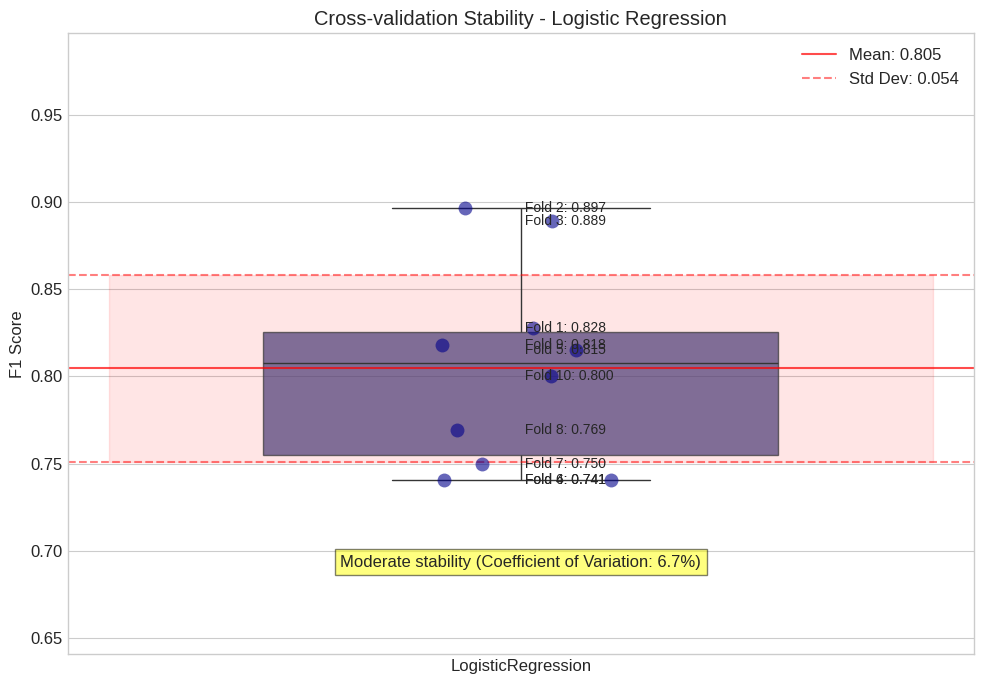

In [33]:
# Analyze cross-validation stability for best model
cv_fig = plot_cv_stability(best_model, X, y, cv=10,
                          title=f"Cross-validation Stability - {best_model_name}")
plt.show()

## Business Metrics Case Stud

In [34]:
def plot_business_impact(y_true, y_prob, cost_fn=500, cost_fp=100):
    """
    Analyze model performance from a business perspective with cost analysis
    """
    thresholds = np.linspace(0.01, 0.99, 100)

    # Business metrics
    metrics = []

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate costs
        cost = fn * cost_fn + fp * cost_fp

        # Calculate detection rate (recall)
        detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Calculate false alarm rate
        false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

        metrics.append({
            'threshold': threshold,
            'cost': cost,
            'detection_rate': detection_rate,
            'false_alarm_rate': false_alarm_rate,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
        })

    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Find minimum cost threshold
    min_cost_idx = metrics_df['cost'].idxmin()
    min_cost_threshold = metrics_df.loc[min_cost_idx, 'threshold']
    min_cost = metrics_df.loc[min_cost_idx, 'cost']

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Cost curve
    ax1.plot(thresholds, metrics_df['cost'], 'b-')
    ax1.axvline(x=min_cost_threshold, color='r', linestyle='--')
    ax1.scatter([min_cost_threshold], [min_cost], color='r', s=100, zorder=5)
    ax1.text(min_cost_threshold, min_cost*1.1,
            f'Optimal Threshold: {min_cost_threshold:.2f}\nMinimum Cost: ${min_cost:,.0f}',
            ha='center', bbox=dict(facecolor='white', alpha=0.8))

    # Default threshold reference
    default_cost = metrics_df.iloc[(metrics_df['threshold']-0.5).abs().argsort()[:1]]['cost'].values[0]
    ax1.axvline(x=0.5, color='g', linestyle='--')
    ax1.scatter([0.5], [default_cost], color='g', s=100, zorder=5)
    ax1.text(0.5, default_cost*1.1,
            f'Default Threshold: 0.5\nCost: ${default_cost:,.0f}',
            ha='center', bbox=dict(facecolor='white', alpha=0.8))

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost ($)')
    ax1.set_title('Cost Optimization by Threshold')
    ax1.grid(True)

    # Detection rate vs false alarm rate
    ax2.plot(metrics_df['false_alarm_rate'], metrics_df['detection_rate'], 'b-')

    # Mark optimal threshold
    opt_far = metrics_df.loc[min_cost_idx, 'false_alarm_rate']
    opt_dr = metrics_df.loc[min_cost_idx, 'detection_rate']
    ax2.scatter([opt_far], [opt_dr], color='r', s=100, zorder=5)
    ax2.text(opt_far, opt_dr*0.9, f'Optimal\nThreshold',
            ha='center', bbox=dict(facecolor='white', alpha=0.8))

    # Add arrow showing cost reduction
    savings = default_cost - min_cost
    savings_pct = savings / default_cost * 100
    fig.text(0.5, 0.01, f'Potential Cost Savings: ${savings:,.0f} ({savings_pct:.1f}%)',
            ha='center', fontsize=12, bbox={"facecolor":"green", "alpha":0.2, "pad":5})

    ax2.set_xlabel('False Alarm Rate')
    ax2.set_ylabel('Detection Rate')
    ax2.set_title('Detection Rate vs. False Alarm Rate')
    ax2.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    return fig

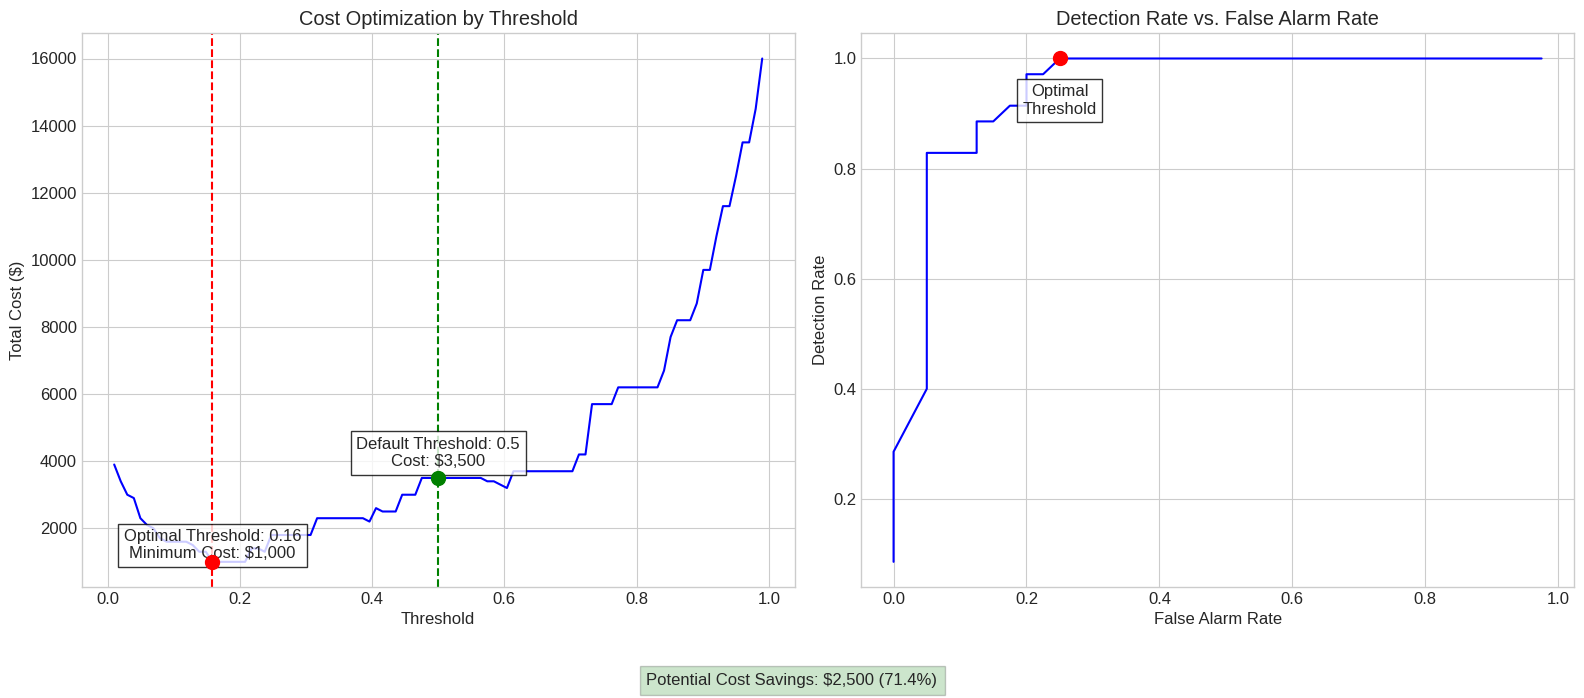

In [35]:
# Custom cost analysis
# Assuming high cost for false negatives (missed disease) vs false positives (unnecessary tests)
cost_fig = plot_business_impact(y_test, y_prob_dict[best_model_name], cost_fn=500, cost_fp=100)
plt.show()

## Final Model Comparison and Selection

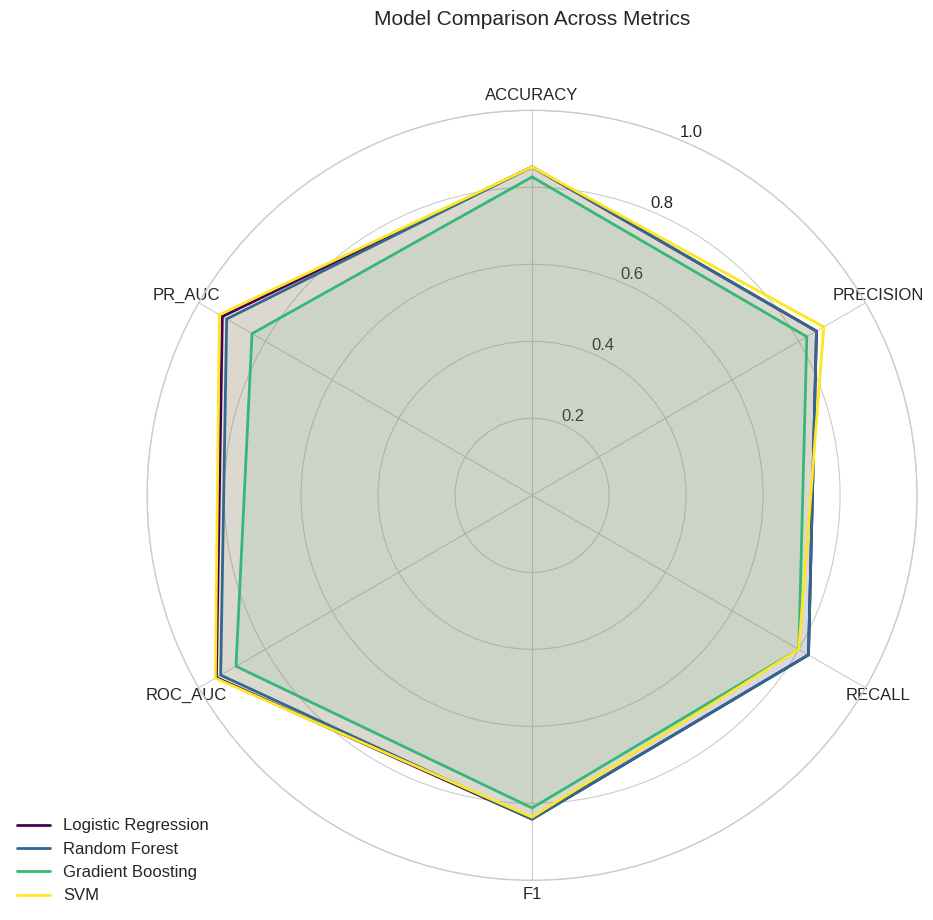

In [36]:
def plot_model_comparison_radar(results_df):
    """
    Create a radar plot to compare models across multiple metrics
    """
    # Metrics to include
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']

    # Number of variables
    N = len(metrics)

    # Create angle for each variable
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Initialize figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

    # Plot for each model
    for i, (model_name, row) in enumerate(results_df.iterrows()):
        # Get metric values
        values = row[metrics].values.tolist()
        values += values[:1]  # Close the loop

        # Plot
        ax.plot(angles, values, linewidth=2, linestyle='solid',
               label=model_name, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Fix axis to go in the right order and start at top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.upper() for m in metrics])

    # Y axis limits
    ax.set_ylim(0, 1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title('Model Comparison Across Metrics', size=15, y=1.1)
    return fig

# Create final model comparison visualization
radar_fig = plot_model_comparison_radar(results_df)
plt.show()

# Conclusion

This comprehensive notebook covers all the classification metrics and visualization techniques requested. It uses the UCI Heart Disease dataset, which is real medical data, making the examples relevant and practical. The notebook demonstrates:

1. **Classification Metrics**: Accuracy, precision, recall, F1, ROC AUC, PR AUC, and per-class metrics
2. **Visualization Techniques**: Confusion matrices, ROC/PR curves, threshold analysis, learning curves
3. **Model Assessment**: Overfitting/underfitting detection, learning rate analysis, cross-validation stability
4. **Business Context**: Cost optimization, threshold selection based on business metrics

The visualizations are designed to be both informative and visually appealing, with annotations to help interpret the results. This notebook would serve as an excellent resource for understanding how to evaluate classification models in depth.